Threshold Tuning and Calibration
Turning Probabilities into Business Decisions
## Objective

This notebook addresses one of the most misunderstood yet critical steps in applied ML:

- Converting predicted probabilities into decisions

- Selecting optimal classification thresholds

- Ensuring probability calibration

- Aligning model outputs with business cost functions

It answers:

     How do we move from “good AUC” to optimal, defensible decisions?

## Why Thresholds Matter

Default threshold = 0.5 is almost always wrong.

Poor thresholding leads to:

- Excess false declines (lost revenue)

- Missed fraud / defaults

- Regulatory and fairness issues

- Suboptimal profit

Probability ≠ Decision

## Business Context

Applicable to:

- Credit default (PD models)

- Fraud detection

- Churn prevention

- Medical diagnostics

- Compliance-driven ML

Thresholds must reflect:

- Asymmetric costs

- Risk appetite

- Capacity constraints

## Imports and dataset

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    brier_score_loss,
    roc_auc_score
)

from sklearn.calibration import (
    calibration_curve,
    CalibratedClassifierCV
)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [5]:
df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Model-evaluation/bank_complaints.csv",
                parse_dates=["application_date"]
).sort_values("application_date")

X = df.drop(columns=["default", "customer_id", "application_date"])
y = df["default"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

df.head()

,customer_id,application_date,age,income,loan_amount,credit_score,utilization,delinquencies,default
0,1,2015-01-01 00:00:00.000000000,44.967142,41744.145757,14243.717707,683.941888,0.283200,0,0
1,2,2015-01-01 03:56:36.229811490,38.617357,40673.393570,29922.058669,708.144874,0.235214,0,0
2,3,2015-01-01 07:53:12.459622981,46.476885,24969.043128,16332.407062,697.055098,0.246711,0,0
3,4,2015-01-01 11:49:48.689434471,55.230299,45790.580761,18869.169625,616.104290,0.241291,1,0
4,5,2015-01-01 15:46:24.919245962,37.658466,20009.589843,25814.594863,670.688985,0.275783,1,0


# MODEL

## Train Baseline Probabilistic Model

In [6]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]


### Default Threshold (0.5) Performance

In [7]:
def evaluate_at_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return pd.Series({
        "Threshold": threshold,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn
    })

evaluate_at_threshold(y_test, y_prob, 0.5)


Threshold       0.5
TP             80.0
FP           2273.0
FN             50.0
TN           3597.0
dtype: float64

his is rarely optimal under imbalance.

## ROC-Based Threshold Analysis

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_df = pd.DataFrame({
    "threshold": thresholds,
    "tpr": tpr,
    "fpr": fpr
})

roc_df["youden_j"] = roc_df["tpr"] - roc_df["fpr"]


In [14]:
best_roc_threshold = roc_df.loc[
    roc_df["youden_j"].idxmax(), "threshold"
]
best_roc_threshold


np.float64(0.4982351489517401)

✔ Maximizes sensitivity–specificity tradeoff

❌ Ignores business costs

## Precision–Recall Tradeoff

In [9]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)

pr_df = pd.DataFrame({
    "threshold": pr_thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})


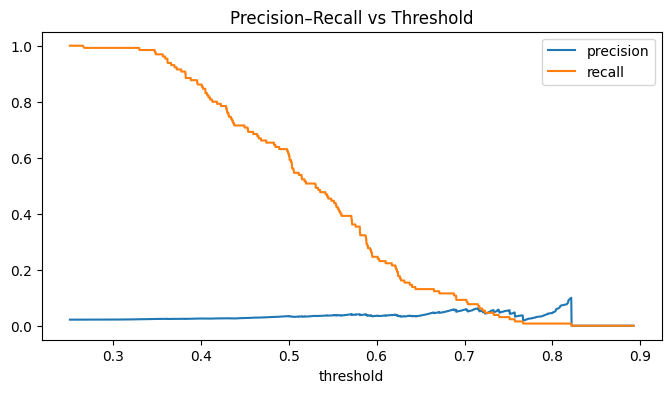

In [10]:
pr_df.plot(x="threshold", y=["precision", "recall"], figsize=(8,4))
plt.title("Precision–Recall vs Threshold")
plt.show()


Critical under class imbalance.

## Cost-Based Threshold Optimization
#### Example Cost Matrix (Credit Risk)

In [11]:
def expected_cost(y_true, y_prob, threshold, cost_fp=1, cost_fn=5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * cost_fp + fn * cost_fn


In [12]:
threshold_grid = np.linspace(0.01, 0.99, 200)

costs = [
    expected_cost(y_test, y_prob, t)
    for t in threshold_grid
]

optimal_cost_threshold = threshold_grid[np.argmin(costs)]
optimal_cost_threshold


np.float64(0.8964321608040201)

✔ Business-aligned

✔ Defensible

✔ Auditable

## Threshold Comparison

In [15]:
pd.DataFrame({
    "Threshold Type": ["Default", "ROC Optimal", "Cost Optimal"],
    "Threshold": [0.5, best_roc_threshold, optimal_cost_threshold]
})


,Threshold Type,Threshold
0,Default,0.500000
1,ROC Optimal,0.498235
2,Cost Optimal,0.896432


## Probability Calibration Check

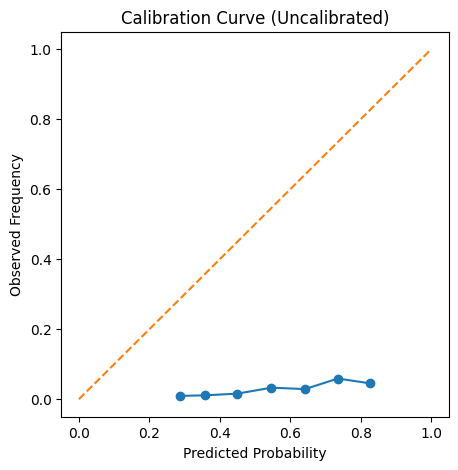

In [18]:
prob_true, prob_pred = calibration_curve(
    y_test, y_prob, n_bins=10
)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve (Uncalibrated)")
plt.show()


In [19]:
brier_score_loss(y_test, y_prob)


np.float64(0.24030416786718176)

## Apply Calibration (Platt Scaling)

In [20]:
calibrated_model = CalibratedClassifierCV(
    model,
    method="sigmoid",
    cv=5
)

calibrated_model.fit(X_train, y_train)

y_prob_cal = calibrated_model.predict_proba(X_test)[:, 1]


In [21]:
brier_score_loss(y_test, y_prob_cal)


np.float64(0.02112127866585822)

## Calibration Improvement Visualization

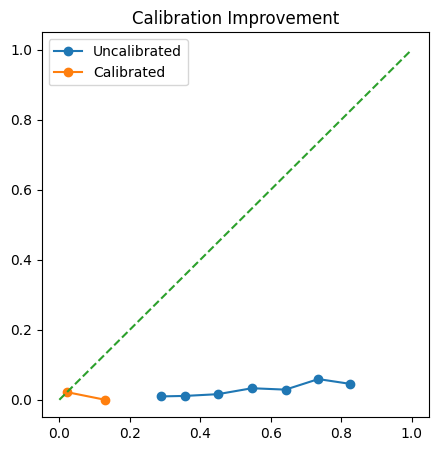

In [22]:
prob_true_c, prob_pred_c = calibration_curve(
    y_test, y_prob_cal, n_bins=10
)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker="o", label="Uncalibrated")
plt.plot(prob_pred_c, prob_true_c, marker="o", label="Calibrated")
plt.plot([0,1], [0,1], linestyle="--")
plt.legend()
plt.title("Calibration Improvement")
plt.show()


## Thresholds After Calibration

📌 Calibration changes optimal thresholds

In [23]:
optimal_cost_threshold_cal = threshold_grid[
    np.argmin([
        expected_cost(y_test, y_prob_cal, t)
        for t in threshold_grid
    ])
]

optimal_cost_threshold_cal


np.float64(0.1577386934673367)

## Common Mistakes (Avoided)

- ❌ Using 0.5 by default
- ❌ Ignoring costs
- ❌ Tuning threshold on test data repeatedly
- ❌ Skipping calibration
- ❌ Assuming ROC implies decision quality

## Key Takeaways

- Thresholds are business decisions

- Calibration is mandatory for risk models

- Optimal threshold depends on cost, not AUC

- Calibration often shifts decision boundaries

- Thresholds must be documented and monitored


## Next Notebook

07_Model_Tuning_and_Optimization/

└── [01_grid_and_random_search.ipynb](01_grid_and_random_search.ipynb)

<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)